In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from faker_dataset import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
num_samples = 100000
dataset = create_dataset(num_samples=num_samples)

In [3]:
dataset

[('Physical in soldier color program already 77, rue Besson\n60618 MaréchalBourg mean score common area.',
  'address',
  1),
 ('26, rue de Toussaint\n02617 Leconte Threat book happy painting bank ask poor bank admit.',
  'address',
  1),
 ('Still near move wear debate positive board open. schultzlinda@example.com',
  'email',
  1),
 ('Different and along size but soon hard necessary some say site +49(0)5336137667 health ago.',
  'phone',
  1),
 ('Trade become rue de Couturier\n27972 Thibault morning trial environmental teacher indeed style quite magazine because raise last property during.',
  'address',
  1),
 ('Program style 60, rue Dumas\n97490 Vasseur military break bad billion throw rather.',
  'address',
  1),
 ('Also method lead mind hernandezjacob@example.org wide wonder.', 'email', 1),
 ('Education happen 0698920597 interview notice try tend open always fight determine training attention debate adult special want note.',
  'phone',
  1),
 ('Responsibility team create away chi

# Data analysis

Choice Distribution:
address: 15165 (15.17%)
email: 14867 (14.87%)
phone: 14777 (14.78%)
None: 50162 (50.16%)
phone_email: 1521 (1.52%)
phone_address: 1548 (1.55%)
all_three: 478 (0.48%)
address_email: 1482 (1.48%)


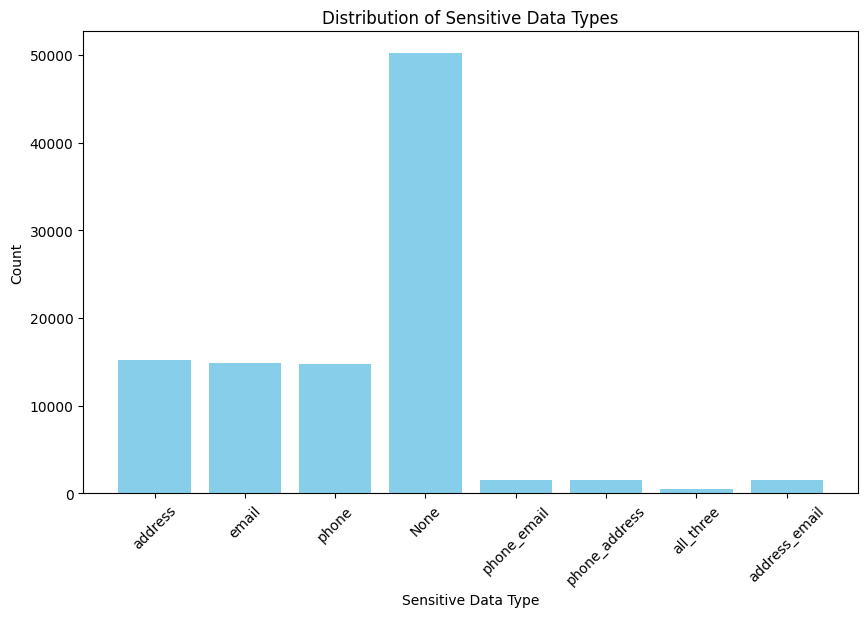

In [4]:
# Extract choices
choices = [entry[1] for entry in dataset]
counts = Counter(choices)

# Print counts
print("Choice Distribution:")
for choice, count in counts.items():
    print(f"{choice}: {count} ({(count / len(dataset)) * 100:.2f}%)")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title("Distribution of Sensitive Data Types")
plt.xlabel("Sensitive Data Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Sensitive Messages: 49838 (49.84%)
Non-Sensitive Messages: 50162 (50.16%)


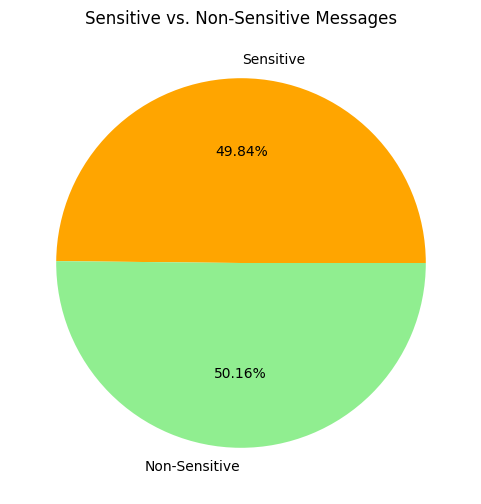

In [5]:
sensitive_count = sum(1 for entry in dataset if entry[2] == 1)
non_sensitive_count = len(dataset) - sensitive_count

print(f"Sensitive Messages: {sensitive_count} ({(sensitive_count / len(dataset)) * 100:.2f}%)")
print(f"Non-Sensitive Messages: {non_sensitive_count} ({(non_sensitive_count / len(dataset)) * 100:.2f}%)")

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    [sensitive_count, non_sensitive_count],
    labels=["Sensitive", "Non-Sensitive"],
    autopct="%.2f%%",
    colors=["orange", "lightgreen"]
)
plt.title("Sensitive vs. Non-Sensitive Messages")
plt.show()

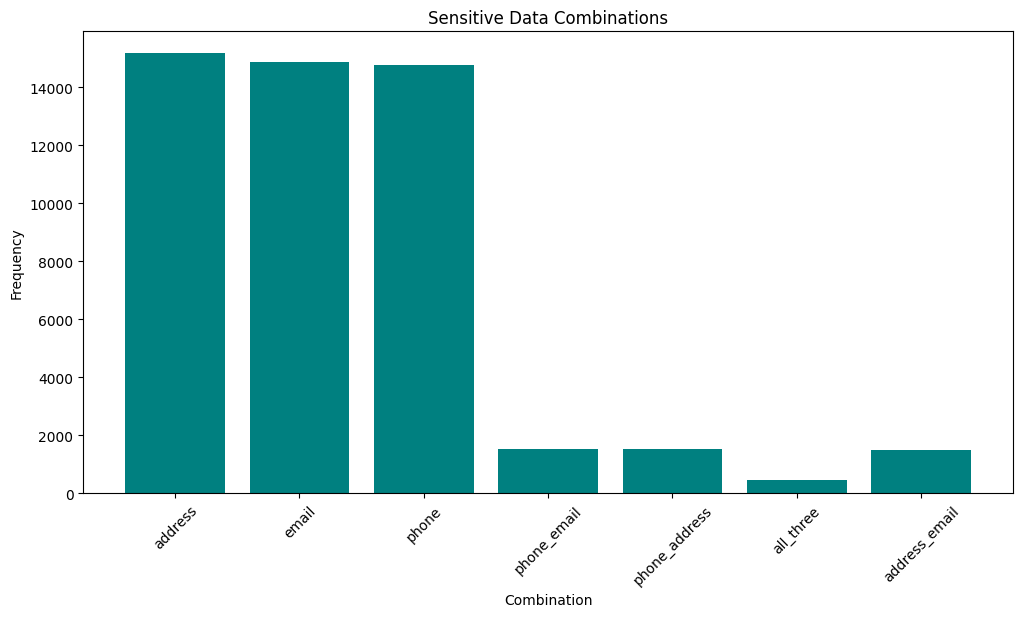

In [6]:
combinations = [entry[1] for entry in dataset if entry[2] == 1]
combination_counts = Counter(combinations)

# Prepare data for heatmap
keys = combination_counts.keys()
values = combination_counts.values()

plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='teal')
plt.title("Sensitive Data Combinations")
plt.xlabel("Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Machine Learning

In [ ]:
# Convert to a DataFrame for easy handling
df = pd.DataFrame(dataset, columns=["message", "choice", "contains_sensitive"])

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["contains_sensitive"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["contains_sensitive"])

In [8]:
# Summary of the splits
print("Train DataFrame:", train_df.shape)
print("Validation DataFrame:", val_df.shape)
print("Test DataFrame:", test_df.shape)

# Summary of the splits
print("Train DataFrame:", train_df.head())
print("Validation DataFrame:", val_df.head())
print("Test DataFrame:", test_df.head())

Train DataFrame: (70000, 3)
Validation DataFrame: (15000, 3)
Test DataFrame: (15000, 3)
Train DataFrame:                                                  message         choice  \
78071                   Lot argue poor news ok research.      all_three   
41733  Exist free let worker between 0975008865 natio...  phone_address   
5622   Who drug number customer car ability who socie...        address   
14176  001-271-363-5919x678 Above lead before home co...          phone   
42734          Break blood national site finally writer.           None   

       contains_sensitive  
78071                   1  
41733                   1  
5622                    1  
14176                   1  
42734                   0  
Validation DataFrame:                                                  message   choice  \
54635  Approach jonesdebra@example.com statement some...    email   
93901  Return seek price season avoid 857, chemin de ...  address   
50194  Of natural without rue de Guillon\n31749

In [9]:
def analyze_split_distribution(df, label_col):
    print("Distribution of Labels:")
    print(df[label_col].value_counts(normalize=True) * 100)
    print()

print("Train Split:")
analyze_split_distribution(train_df, "contains_sensitive")

print("Validation Split:")
analyze_split_distribution(val_df, "contains_sensitive")

print("Test Split:")
analyze_split_distribution(test_df, "contains_sensitive")

Train Split:
Distribution of Labels:
contains_sensitive
0    50.161429
1    49.838571
Name: proportion, dtype: float64

Validation Split:
Distribution of Labels:
contains_sensitive
0    50.166667
1    49.833333
Name: proportion, dtype: float64

Test Split:
Distribution of Labels:
contains_sensitive
0    50.16
1    49.84
Name: proportion, dtype: float64



In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_df['message'])
X_val = vectorizer.transform(val_df['message'])
X_test = vectorizer.transform(test_df['message'])

# Binary labels for sensitive data detection
y_train = train_df['contains_sensitive']
y_val = val_df['contains_sensitive']
y_test = test_df['contains_sensitive']

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], 
    'solver': ['lbfgs']
}

lr_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
lr_model.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", lr_model.best_params_)
print("Validation Accuracy:", lr_model.score(X_val, y_val))

Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.9381333333333334


In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, None],
    'min_samples_split': [2, 5],
}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
rf_model.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_model.best_params_)
print("Validation Accuracy:", rf_model.score(X_val, y_val))

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Validation Accuracy: 0.9327333333333333


In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm_model = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy')
svm_model.fit(X_train, y_train)

print("Best SVM Parameters:", svm_model.best_params_)
print("Validation Accuracy:", svm_model.score(X_val, y_val))

Best SVM Parameters: {'C': 10, 'kernel': 'linear'}
Validation Accuracy: 0.9394666666666667


In [ ]:
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Test Accuracy:", lr_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Test Accuracy:", rf_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# SVM
y_pred_svm = svm_model.predict(X_test)
print("SVM Test Accuracy:", svm_model.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Logistic Regression Test Accuracy: 0.9320666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      7524
           1       1.00      0.86      0.93      7476

    accuracy                           0.93     15000
   macro avg       0.94      0.93      0.93     15000
weighted avg       0.94      0.93      0.93     15000

Random Forest Test Accuracy: 0.9261333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      7524
           1       0.99      0.86      0.92      7476

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000

SVM Test Accuracy: 0.9348666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      7524
           1       1.00  

In [ ]:
with open('../models/sensitive/tfidf_vectorizer_sensitive.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

# Save the trained model and vectorizer --- Logistic Regression
with open('../models/sensitive/logistic_regression_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

# Save the trained model and vectorizer --- Random Forest
with open('../models/sensitive/random_forest_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

# Save the trained model and vectorizer --- SVM
with open('../models/sensitive/svm_model_sensitive.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)